In [1528]:
# Just some notes of things I'm running into:
    # 1. not all tables are upright and this causes issues with camelot.read_pdf
    # I addressed this 
    # 2. some bolded numbers read in as double (e.g., 1313 instead of 13)
    # 3. headers are different for different files
    # 4. getting metadata about sites, directions, etc.

In [1]:
# this will give some nice tips on nice coding in python
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [315]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import re
import glob
import os
import camelot
import seaborn as sns

In [144]:
# setting some global variables/paths for later
OUTDIR = '/Users/chad/Desktop/traffic_pdfs/'
PDF_DIR = os.path.join(OUTDIR + "pdfs")
PDF_FILES = glob.glob("%s/*.pdf" % PDF_DIR)

# search for PDF_FILES from 2024
# Our blocks data 613 S Grove June- 
[x for x in PDF_FILES if re.search('2024', x)]

['/Users/chad/Desktop/traffic_pdfs/pdfs/2024-08-12-transportation-commission-agenda_0.pdf',
 '/Users/chad/Desktop/traffic_pdfs/pdfs/2024-07-08-transportation-commission-agenda_0.pdf',
 '/Users/chad/Desktop/traffic_pdfs/pdfs/2024-01-08-transportation-commission-agenda_0.pdf',
 '/Users/chad/Desktop/traffic_pdfs/pdfs/2024-02-12-transportation-commission-agenda_0.pdf',
 '/Users/chad/Desktop/traffic_pdfs/pdfs/2024-04-08-transportation-commission-agenda_0.pdf',
 '/Users/chad/Desktop/traffic_pdfs/pdfs/2024-06-10-transportation-commission-agenda_0.pdf']

In [5]:
def clean_table(table):
    pd.set_option('future.no_silent_downcasting', True)
    newtable = table
    nan_value = float("NaN")
    df = newtable.df
    df.replace("", nan_value, inplace=True)
    df.dropna(thresh=10, axis=1, inplace=True) # axis = 1 means 'columns'
    df.dropna(thresh=10, axis=0, inplace=True) # axis = 0 means rows (i.e. 'index')
    df.replace("\\(cid\\:\\d+\\)", nan_value, inplace=True, regex=True)
    newtable.df = df
    if (len(df) > 0):
        return(newtable)
    else:
        return(None)

In [145]:
# function to locate and fix problematic cells
# e.g., 4 digits, 2 sets of repeating - 1313 should be 13
def fix_nums(string):
    if len(string) > 3 and len(string) % 2 == 0:
        slen2 = round(len(string)/2)
        return(re.sub('(\d{'+str(slen2)+',})\\1+', '\\1', string=string))
    else:
        return(string)

# check that it's working
print(fix_nums('123123')) # returns 123
print(fix_nums('11')) # returns 11 - we only want it to work on numbers with 4 digits or more

123
11


In [ ]:
# uncomment to restart
# urls = []

In [205]:
# this chunk will crawl the Oak Park website searching for PDFs of past traffic meetings

from datetime import date, timedelta
import requests

# Function to give a date range
def daterange(start_date: date, end_date: date):
	days = int((end_date - start_date).days)
	for n in range(days):
		yield start_date + timedelta(n)

# Function to check if a url exists
def check_url_exists(url: str):
	return requests.head(url, allow_redirects=True, timeout=10).status_code == 200

In [ ]:
# Set start and end dates for crawling web
# Last 10 years (2014/8/12 to 2024/8/12)
start_date = date(2014, 8, 12)
end_date = date(2024, 8, 12)

# Crawl Oak Park website looking for PDF files on specific dates
for target_date in daterange(start_date, end_date):
	date_fmt = target_date.strftime("%Y-%m-%d")
	print(date_fmt)
	url = 'https://www.oak-park.us/sites/default/files/meeting-resources/' + date_fmt + '-transportation-commission-agenda_0.pdf'
	if check_url_exists(url):
		print('Found a record on ' + date_fmt)
		urls.append(url)

# Save output to TXT file
with open(OUTDIR + "/urls.txt", "w") as outfile:
	outfile.write("\n".join(urls))

In [246]:
# Now we download the found PDFs-

import urllib.request

for url in urls:
	name = url.rsplit('/', 1)[-1]
	filename = os.path.join(OUTDIR + "pdfs", name)
	if not os.path.isfile(filename):
		urllib.request.urlretrieve(url, filename)

In [ ]:
# next we rotate PDF pages if text is not upright
# NB: this improved table extraction by XX% (TODO get this number)

import pdfplumber
from pypdf import PdfReader, PdfWriter

# create path for output (rotated) PDFs if it doesn't already exist
newpath = '/Users/chad/Desktop/traffic_pdfs/pdfs_rotated/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

for PDF in PDF_FILES:

    print('Working on ' + PDF + '...')
    
    print('Finding text orientations...')
    
    # NB: this chunk rotate pages if the text is not already upright
    # TODO might need to check that it works in all cases, I think it
    # is rotating only based on the first instance of text not upright

    # figure out if text is upright or not
    tmp = pdfplumber.open(PDF)
    chars = [page.chars[0] if len(page.chars) > 0 else None for page in tmp.pages]
    is_upright = [re.findall("'upright': (True|False)", str(x))[0] if x != None else 'True' for x in chars]
    
    print('Rotating pages...')
    
    # read file
    reader = PdfReader(PDF)
    writer = PdfWriter()
    
    # rotate alternate pages
    for page_num in range(len(is_upright)):
        page = reader.pages[page_num]
        if is_upright[page_num] == 'True': 
            writer.add_page(page)
        elif is_upright[page_num] == 'False':
            writer.add_page(page.rotate(90))
    
    # write rotated PDF to a file
    with open(PDF.replace('/pdfs/', '/pdfs_rotated/'), "wb") as fp:
        writer.write(fp)

In [14]:
# Setup some variables
NAN_VALUE = float("NaN")
pd.set_option('future.no_silent_downcasting', True) # can't remember what this was for

# Function to clean tables (remove NAs, etc)
def clean_table(tab):    
    tab.df.replace("", "NaN", inplace=True)
    tab.df.dropna(thresh=10, axis=1, inplace=True) # axis = 1 means 'columns'
    tab.df.dropna(thresh=10, axis=0, inplace=True) # axis = 0 means rows (i.e. 'index')
    tab.df.replace("\\(cid\\:\\d+\\)", "NaN", inplace=True, regex=True)
    if (len(tab.df) == 0):
        return
    else:
        return tab

In [9]:
# Function to split columns when there is only 1 column
def split_cols(tab):
    if len(tab.cols) < 3:
        df = tab.df[0]
        ncol = len(df[11].split())
        tab.df = df.str.split(n=ncol, expand=True)
    return(tab)

# testing
# pdf = '/Users/chad/Desktop/traffic_pdfs/pdfs/2023-03-14-transportation-commission-agenda_0.pdf'
# tmp = camelot.read_pdf(pdf, pages='80', flavor='stream', strip_text='\n', suppress_stdout=True)
# split_cols(tmp[0]).df

In [ ]:
# Using insert to put stuff at a specific position in a list
# fruits = ['apple', 'banana', 'cherry']
# fruits.insert(0, 'orange')
# fruits

In [ ]:
# Now extract tables from all PDFs in folder - takes ~15s per PDF

PDF_DIR_ROT = '/Users/chad/Desktop/traffic_pdfs/pdfs_rotated/'
PDF_FILES_ROT = glob.glob("%s/*.pdf" % PDF_DIR_ROT)

# create a blank list for tables - uncomment to run!
# RAW_TABLES = []

# NB: we're missing a lot of tables from older PDFs (e.g., xx)

# TODO work on adding progress bar

for pdf in PDF_FILES_ROT:
    print('Processing ' + pdf + '...')
    # read tables with camelot
    try:
        in_tables = camelot.read_pdf(pdf, pages='all', flavor='stream', strip_text='\n', suppress_stdout=True)
    except:
        next    
    # in_tables = camelot.read_pdf(pdf, pages='all', flavor='stream', strip_text='\n', suppress_stdout=True)
    out_tables = in_tables[:] # NB: I learned out_tables = in_tables modifies original in_tables! Using `[:]` copies whole list
    # only keep tables with >24 rows (hrs in day)
    out_tables = [x for x in in_tables if len(x.rows) > 24]    

    # TODO write line that checks for data pattern and split columns, keep table if so
    # split some columns up - e.g., file XX
    # if len(out_tables) == 1:
    # out_tables = [split_cols(x) for x in out_tables]
    
    # clean tables (remove NAs, etc)
    out_tables = [clean_table(x) for x in out_tables]
    # add file name at 0 index for accessing later
    out_tables.insert(0, pdf)    
    # append to list of all tables for all PDF files
    RAW_TABLES.append([x for x in out_tables if x is not None])

In [677]:
pdf = "/Users/chad/Desktop/traffic_pdfs/pdfs_rotated/2016-11-28-transportation-commission-agenda_0.pdf"

# RAW_TABLES
# ALL_TABLES[38][1].df

tmp = camelot.read_pdf(pdf, pages='all', flavor='stream', strip_text='\n', suppress_stdout=True)



In [690]:
parse_table(clean_table(tmp[49])).df

,010,1115,1620,2125,2630,3135,3640,4145,4650,5155,5660,6165,6670,71120
0,,,,,,,,,,,,,,
12 PM,1.0,2.0,8.0,16.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13:00,1.0,5.0,10.0,13.0,10.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14:00,1.0,3.0,15.0,28.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15:00,2.0,11.0,17.0,55.0,24.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16:00,0.0,6.0,15.0,45.0,28.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17:00,1.0,2.0,8.0,46.0,24.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18:00,1.0,1.0,3.0,44.0,27.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19:00,1.0,1.0,6.0,20.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20:00,0.0,0.0,6.0,11.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# make a copy for later
ALL_TABLES = RAW_TABLES[:]

In [2794]:
# target (raw) table

PDF_INDEX = 14
PAGE_INDEX = 6

df = DATA_TABLES[PDF_INDEX][PAGE_INDEX].df

df.head()

# here is where I can get the text for regex-
# DATA_TABLES[14][7].data

# patterns to search for (maybe):
# '> \d - \d

# re.findall('>\s*([\d\.]*)([\s\-]*)([\d\.]*)', str(DATA_TABLES[14][7].data))


,0,1,3,5,7,9,11,13,15,17,19,21,23,25
7,12:00 AM,2,0,0,0,0,0,0,1,0,0,0,0,3
8,1:00,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2:00,0,0,0,0,0,0,0,0,0,0,0,0,0
10,3:00,0,0,0,0,0,0,0,0,0,0,0,0,0
11,4:00,0,0,0,0,0,0,0,0,0,0,0,0,0


In [268]:
# this function parses and cleans up tables found by camelot

# TODO clean this up

import copy

def parse_table(table, silent=False):

    outtable = copy.copy(table)
    
    df = outtable.df
    df = df.set_index(df.columns[0], drop=True)  # works?

    # check if all NAs
    if all(df.isnull().values.all(axis=0)):
        # TODO I know there must be a better way than having all these 'if not silent's...
        if not silent:
            print('No time-by-speed data sets found')
        return(None)

    # check if too few rows (should be at least 24, using 10 here)
    if len(df) < 10:
        if not silent:
            print('No time-by-speed data sets found')
        return(None)
    
    # remove double numbers
    df = df.map(fix_nums, na_action='ignore')
    
    # remove rows that contain any percentages
    m = ~df.apply(lambda x: x.str.contains('\%')).any(axis=1)
    df = df[m]
    
    # filter out columns with any cells that have '-'
    m = ~df.apply(lambda x: x.str.contains('-')).any(axis=0)
    df = df[df.columns[m]]

    if len(df.columns) == 0:
        if not silent:
            print('No time-by-speed data sets found')
        return(None)
    
    # force to numeric so we can get row sums
    tmp = df.apply(pd.to_numeric, errors='coerce')

    # check
    if len(tmp) < 24:
        if not silent:
            print('No time-by-speed data sets found')
        return None
    
    # calculate row sums
    row_sums = tmp.sum(axis=1)
    
    # get row index where sum is < 100 (previously I had 10)
    idx = list(map(lambda i: i < 100, row_sums)).index(True)
    # NB it might be better to look for date or 12:00 AM in time column
    
    # now use index to subset rows from midnight to 24 hrs later
    df1 = df.iloc[idx:(idx+24),:]
    # TODO check if this gets messed up in some cases
    
    # these are the ones we'll paste together for column names
    colnames = df.iloc[0:idx,:].astype(str).apply('sum', axis=0)
    df1.columns = colnames

    # here's something I was working on to find headers when they are truncated
    # list(map("  ".join, zip(*DATA_TABLES[PDF_INDEX][PAGE_INDEX].data[5:7])))

    # force to numerice so we can calculate sums with the dropsums function
    tmp = df1.apply(pd.to_numeric, errors='coerce')
    
    # produce a cleaned matrix for plotting by dropping columns after the sum column
    df = dropsums(tmp)
    
    if df is not None:
        df = df.astype(float)
        outtable.df = df
        # return(df)
        return(outtable)
    else:
        if not silent:
            print('No time-by-speed data sets found')
        return(None)


In [269]:
# flatten list of lists

FLAT_TABLES = []

for xs in DATA_TABLES:
    for x in xs[1:]:
        x.file = xs[0] # set file attritube for later
        FLAT_TABLES.append(x)

FLAT_TABLES[0].file  # cool it's working

'/Users/chad/Desktop/traffic_pdfs/pdfs_rotated/2021-01-12-transportation-commission-agenda_0.pdf'

In [270]:
FLAT_TABLES[1].df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
1,Start,1,6,11,16,21,26,31,36,41,46,51,56,61,66,71,76,NaN
2,Time,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,9999,Total
3,02/20/20,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,3
4,01:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,02:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,03:00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
7,04:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,05:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,06:00,0,0,0,0,4,1,2,0,0,0,0,0,0,0,0,0,7
10,07:00,0,0,0,3,2,3,2,0,0,0,0,0,0,0,0,0,10


In [786]:
# now find and filter out all time x speed tables

DATA_TABLES_CLEAN = []

for i in range(len(FLAT_TABLES)):
    tab = FLAT_TABLES[i]
    try:
        out = parse_table(tab, silent=False)
        DATA_TABLES_CLEAN.append(out)
    except:
        next

No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by-speed data sets found
No time-by

In [787]:
print(str(len(DATA_TABLES_CLEAN)) + ' total tables') # 575 tables

# drop empty tables
DATA_TABLES_CLEAN = [x for x in DATA_TABLES_CLEAN if x is not None]

# drop tables with only one column
DATA_TABLES_CLEAN = [x for x in DATA_TABLES_CLEAN if len(x.df.columns) != 1]

print(str(len(DATA_TABLES_CLEAN)) + ' non-empty tables') # 334 non-empty tables

# NB: this is just for debugging-
# for i in range(0, len(FLAT_TABLES), 1):
#     print(i)
#     find_table(FLAT_TABLES[i])


575 total tables
334 non-empty tables


In [788]:
# [x.shape for x in DATA_TABLES_CLEAN]

# get stats
tot_rows = sum([len(x.df) for x in DATA_TABLES_CLEAN])
tot_cols = sum([len(x.df.columns) for x in DATA_TABLES_CLEAN])
tot_cells = sum([len(x.df.columns)*len(x.df) for x in DATA_TABLES_CLEAN])

# print out summaries of tables found
print(str(tot_rows) + ' total rows')
print(str(tot_cols) + ' total columns')
print(str(tot_cells) + ' total cells')



# 5064 2758 66192
# 8016 4375 105000 cells now


# TODO figure out how to get column names (speed classes)



# TODO copy the attributes over



# TODO figure out how to turn this into a massive data frame and output the data


# TODO figure out how to merge speed classes together for different years




8016 total rows
4375 total columns
105000 total cells


In [789]:
# [x.columns for x in DATA_TABLES_CLEAN]

df = DATA_TABLES_CLEAN[68].df # bad one
# DATA_TABLES_CLEAN[5] # good one

df.columns


Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype='object')

In [790]:
# setup sequence of times starting at midnight (hours_00) and noon (hours_12)
hours_00 = []
hours_12 = []

for i in range(0,24,1):
    hours_00.append(str.rjust(str(i),2,'0') + ":00")

for i in range(12,36,1):
    if i > 23:
        i = i - 24
    hours_12.append(str.rjust(str(i),2,'0') + ":00")

hours_00

['00:00',
 '01:00',
 '02:00',
 '03:00',
 '04:00',
 '05:00',
 '06:00',
 '07:00',
 '08:00',
 '09:00',
 '10:00',
 '11:00',
 '12:00',
 '13:00',
 '14:00',
 '15:00',
 '16:00',
 '17:00',
 '18:00',
 '19:00',
 '20:00',
 '21:00',
 '22:00',
 '23:00']

In [791]:
# DATA_TABLES_CLEAN[0].df.index[1]
set([x.df.index[1] for x in DATA_TABLES_CLEAN])

{'01:00', '01:00 AM', '13:00', '1:00'}

In [792]:
# [x.columns[0] for x in DATA_TABLES_CLEAN]
# [x.columns[0] for x in DATA_TABLES_CLEAN]

# write a small function that splits up column names

for tab in DATA_TABLES_CLEAN:
    # here we are replacing some known column names
    tab.df.rename(columns={'010': '0-10', '110': '1-10', '115': '1-15', '15': '1-5', '610': '6-10'}, inplace=True)
    # here we are substituting 4 digit values (e.g., 1120) with 11-20
    tab.df.rename(columns=lambda x: re.sub('(\d{2,2})(\d{2,2})','\\1-\\2',str(x)), inplace=True)

# this is a big assumption here! some dates start at 12 PM rather than 12 AM (the usual)
hours = pd.date_range("00:00", "23:00", freq="60min").strftime('%H:%M')

for tab in DATA_TABLES_CLEAN:
    if tab.df.index[1] in ['01:00','01:00 AM', '1:00']:
        tab.df.index = hours_00
    elif tab.df.index[1] == '13:00':
        tab.df.index = hours_12

In [793]:
from PyPDF2 import PdfReader

# len(DATA_TABLES_CLEAN)

# DATA_TABLES_CLEAN[200].file

page = DATA_TABLES_CLEAN[200].page
pdf = DATA_TABLES_CLEAN[200].file

reader = PdfReader(pdf)
page_ext = reader.pages[page-1]
text = page_ext.extract_text()

print(pdf)
print('page ' + str(page))

print('-------------------------------------------------------------------------------------------')
print(text)

print(DATA_TABLES_CLEAN[200].df.head(10))


/Users/chad/Desktop/traffic_pdfs/pdfs_rotated/2020-01-27-transportation-commission-agenda_0.pdf
page 52
-------------------------------------------------------------------------------------------
Page 2
Oak Park
Wisconsin AvenueFillmore Street & Roosevelt RoadFish Transportation Group
1800 Des Plaines Avenue  Suite 103
Forest Park, IL  60130
SB
Start 1 11 16 21 26 31 36 41 46 51 56 61 66
Time 10 15 20 25 30 35 40 45 50 55 60 65 70 Total
12/05/19 0 0 0 0 0 1 0 0 0 0 0 0 0 1
01:00 0 0 0 0 0 0 0 0 0 0 0 0 0 002:00 0 0 0 0 0 0 0 0 0 0 0 0 0 0
03:00 0 0 0 0 0 0 0 0 0 0 0 0 0 0
04:00 0 0 0 0 0 0 0 0 0 0 0 0 0 0
05:00 0 0 0 0 1 0 0 0 0 0 0 0 0 1
06:00 0 0 1 1 0 2 0 0 0 0 0 0 0 4
07:00 0 0 1 2 6 1 0 0 0 0 0 0 0 1008:00 3 0 0 8 9 3 0 0 0 0 0 0 0 23
09:00 1 0 1 13 16 3 1 0 0 0 0 0 0 35
10:00 0 1 0 4 5 2 0 0 0 0 0 0 0 12
11:00 0 0 2 6 13 3 0 0 0 0 0 0 0 24
1 2  P M0023410000000 1 0
13:00 0 0 3 10 8 0 0 0 0 0 0 0 0 21
14:00 0 2 7 6 9 1 0 0 0 0 0 0 0 25
15:00 0 0 6 2 5 1 0 0 0 0 0 0 0 14
16:00 2 2 

In [794]:
len(set([x.file for x in DATA_TABLES_CLEAN]))  # 19 unique dates (16 below, I think because some headers not read)

19

In [795]:
# print(DATA_TABLES_CLEAN[10].head())
# print(DATA_TABLES_CLEAN[110].head())

# TODO: write some code that fixes up the speed classes
# in 2021 they go by 5s 1-5, 6-10, 11-15, 16-20, 21-25, 26-30, etc.
# in 2024 they go 0-15, 15-17.5, 17.5-20, 20-22.5, 22.5-25, 25-27.5, 27.5-30, 30-35, 35-40, 40-45, 45-50...
# merge 2021 1-15 (3 bins) into 2024 1 bin
# merge 2024 bins (15-17.5, 17.5-20) into 2021 16-20 bin
# merge 2024 bins (20-22.5, 22.5-25) into 2021 21-25 bin
# merge 2024 bins (25-27.5, 27.5-30) into 2021 26-30 bin

# a graphical way of looking at it
# .....|.....|.....|.....|
# ...........|.....|.....|

# probably a good way to do it would be to create a huge dataframe
# then have columns with min/max in a bin and work with merging there
# e.g., if speed > 60 create a sum column..
# I should probably be thinking about the final analyses I want to do

# DATA_TABLES_CLEAN[10]['1-5'] + DATA_TABLES_CLEAN[10]['6-10']

# get breakpoints

colnames = []

for tab in DATA_TABLES_CLEAN:
    colnames.append(tab.df.columns.tolist())

# set(colnames)

colnames_flat = []

for xs in colnames:
    for x in xs:
        colnames_flat.append(x)

# unique column names (i.e. speed range bins)
set(colnames_flat)

{'0',
 '0-10',
 '1-10',
 '1-15',
 '1-5',
 '11-15',
 '16-20',
 '21-25',
 '26-30',
 '31-35',
 '36-40',
 '41-45',
 '46-50',
 '51-55',
 '56-60',
 '6-10',
 '61-65',
 '66-70',
 '71-120',
 '71-75',
 '76-99',
 '76-999'}

In [796]:
# testing zone

tab = DATA_RECTIFIED[0]
newdf = tab.df
newdf

if {'1-5','6-10','11-15'}.issubset(set(newdf.columns)):
    newdf['1-15'] = newdf['1-5'] + newdf['6-10'] + newdf['11-15']
    newdf = newdf.drop(['1-5','6-10','11-15'], axis=1)
    newdf = newdf.reindex(sorted(newdf.columns), axis=1)

newdf

,time,1-15,16-20,21-25,26-30,31-35,36-40,41-45,46-50,51-55,56-60,61-65,66-70,71-75,76-99
0,00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,06,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,07,0.0,5.0,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,08,0.0,3.0,7.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,09,0.0,3.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [797]:
# writing a function to locate duplicated entries in a list
def find_dups(x: list):
    dups = []
    isdup = []
    for item in x:
        if item in dups:
            isdup.append(1)
        else:
            isdup.append(0)
            dups.append(item)
    return(isdup)
    # return(sorted(dups))

In [798]:
# reshape individual per-date/site dataframes and concatenate into a big dataframe:

# make a "deep" copy
DATA_RECTIFIED = copy.deepcopy(DATA_TABLES_CLEAN)

DAT_RESHAPE = []

# reshape from wide to long format
for tab in DATA_RECTIFIED:
    newdf = tab.df
    # here is a potential way to merge data in some bins-
    if {'1-5','6-10','11-15'}.issubset(set(newdf.columns)):
        newdf['1-15'] = newdf['1-5'] + newdf['6-10'] + newdf['11-15']
        newdf.drop(['1-5','6-10','11-15'], axis=1, inplace=True)
    if {'0-10','11-15'}.issubset(set(newdf.columns)):
        newdf['1-15'] = newdf['0-10'] + newdf['11-15']
        newdf.drop(['0-10','11-15'], axis=1, inplace=True)
    if {'1-10','11-15'}.issubset(set(newdf.columns)):
        newdf['1-15'] = newdf['1-10'] + newdf['11-15']
        newdf.drop(['1-10','11-15'], axis=1, inplace=True)

# resort columns
for tab in DATA_RECTIFIED:
    tab.df = tab.df.reindex(sorted(tab.df.columns), axis=1)

# add time index
for tab in DATA_RECTIFIED:
    tab.df = tab.df.reset_index(names='time')

# find duplicates
# now find dups
file_names = [x.file for x in DATA_RECTIFIED]
dups = find_dups(file_names)
dups[0:10]

# create block names (unique IDs restarting numbers at new file/date)
blocks = []
for i in range(len(dups)):
    if dups[i]==0:
        blocks.append(1)
    elif dups[i]==1:
        blocks.append(blocks[i-1]+1)
blocks[0:25]

# reshape and combine dataframes
for i in range(len(DATA_RECTIFIED)):
    tab = DATA_RECTIFIED[i]
    newdf = pd.melt(tab.df, id_vars='time', var_name='speed', value_name='count')
    newdf['date'] = re.findall('(\d+-\d+-\d+)', tab.file)[0]
    newdf['date'] = pd.to_datetime(newdf['date'])
    newdf['block'] = blocks[i]
    
    # append to the final dataframe
    DAT_RESHAPE.append(newdf)

In [799]:
# Take a look to see if it's working
DAT_RESHAPE[17]

,time,speed,count,date,block
0,00:00,1-15,0.0,2019-05-30,1
1,01:00,1-15,0.0,2019-05-30,1
2,02:00,1-15,1.0,2019-05-30,1
3,03:00,1-15,0.0,2019-05-30,1
4,04:00,1-15,1.0,2019-05-30,1
...,...,...,...,...,...
283,19:00,66-70,0.0,2019-05-30,1
284,20:00,66-70,0.0,2019-05-30,1
285,21:00,66-70,0.0,2019-05-30,1
286,22:00,66-70,0.0,2019-05-30,1


In [800]:
# concatenate
bigdf = pd.concat(DAT_RESHAPE)

# remove problematic entries without a speed range
bigdf = bigdf[bigdf['speed']!='0']

# split speed variable into new speed_min and speed_max columns
bigdf[['speed_min', 'speed_max']] = bigdf['speed'].str.split('-', n=1, expand=True)

# remove speed variable
# bigdf.drop('speed', axis=1, inplace=True)

# convert speeds to floating
bigdf[['speed_min','speed_max']] = bigdf[['speed_min','speed_max']].astype(float)

# checking for any NA dates- seems to be OK
# any(bigdf['date'].isnull())

bigdf # 46800 rows --> now it's 85608 (after importing last 10 years) --> 81768 now after merging speed classes

sum(bigdf['count'][bigdf['speed_min'] > 60]) # nothing more than 60 so OK to drop these speed classes

bigdf = bigdf[bigdf['speed_min'] < 60] # nothing more than 60 so OK to drop these speed classes

bigdf # 66984 rows now -> 64320 now

,time,speed,count,date,block,speed_min,speed_max
0,00:00,1-15,0.0,2021-01-12,1,1.0,15.0
1,01:00,1-15,0.0,2021-01-12,1,1.0,15.0
2,02:00,1-15,0.0,2021-01-12,1,1.0,15.0
3,03:00,1-15,0.0,2021-01-12,1,1.0,15.0
4,04:00,1-15,0.0,2021-01-12,1,1.0,15.0
...,...,...,...,...,...,...,...
235,19:00,56-60,0.0,2017-06-12,18,56.0,60.0
236,20:00,56-60,0.0,2017-06-12,18,56.0,60.0
237,21:00,56-60,0.0,2017-06-12,18,56.0,60.0
238,22:00,56-60,0.0,2017-06-12,18,56.0,60.0


In [801]:
# here's what i might be able to do

import numpy as np
# start with lowest speed_min (=1) and figure out what date has the biggest range (speed_max - speed_min)
# use that range (I think it will be 1-15 MPH) to summarize other dates/times (i.e. 1-5 + 6-10 + 11-15 = 1-15)
# 

bigdf['range'] = bigdf['speed_max'] - bigdf['speed_min']

min(bigdf['speed_min'])

min_speed = bigdf[bigdf['speed_min']==1]

min_speed[min_speed['range']==max(min_speed['range'])]

# ok- now do I bin smaller speed bins into bigger ones?
# or divide a bigger bin into equal subbins (e.g., if 12 cars in 1-15 MPH can say 4 in 1-5, 4 in 6-10, and 4 in 11-15 MPH)?

np.unique(bigdf[['speed_min','speed_max']], axis=0) # working! 10 unique speed classes

array([[ 1., 15.],
       [16., 20.],
       [21., 25.],
       [26., 30.],
       [31., 35.],
       [36., 40.],
       [41., 45.],
       [46., 50.],
       [51., 55.],
       [56., 60.]])

In [802]:
bigdf[bigdf['date']=='2016-11-28']

,time,speed,count,date,block,speed_min,speed_max,range
0,12:00,1-15,2.0,2016-11-28,1,1.0,15.0,14.0
1,13:00,1-15,4.0,2016-11-28,1,1.0,15.0,14.0
2,14:00,1-15,4.0,2016-11-28,1,1.0,15.0,14.0
3,15:00,1-15,2.0,2016-11-28,1,1.0,15.0,14.0
4,16:00,1-15,2.0,2016-11-28,1,1.0,15.0,14.0
...,...,...,...,...,...,...,...,...
235,19:00,56-60,0.0,2016-11-28,24,56.0,60.0,4.0
236,20:00,56-60,0.0,2016-11-28,24,56.0,60.0,4.0
237,21:00,56-60,0.0,2016-11-28,24,56.0,60.0,4.0
238,22:00,56-60,0.0,2016-11-28,24,56.0,60.0,4.0


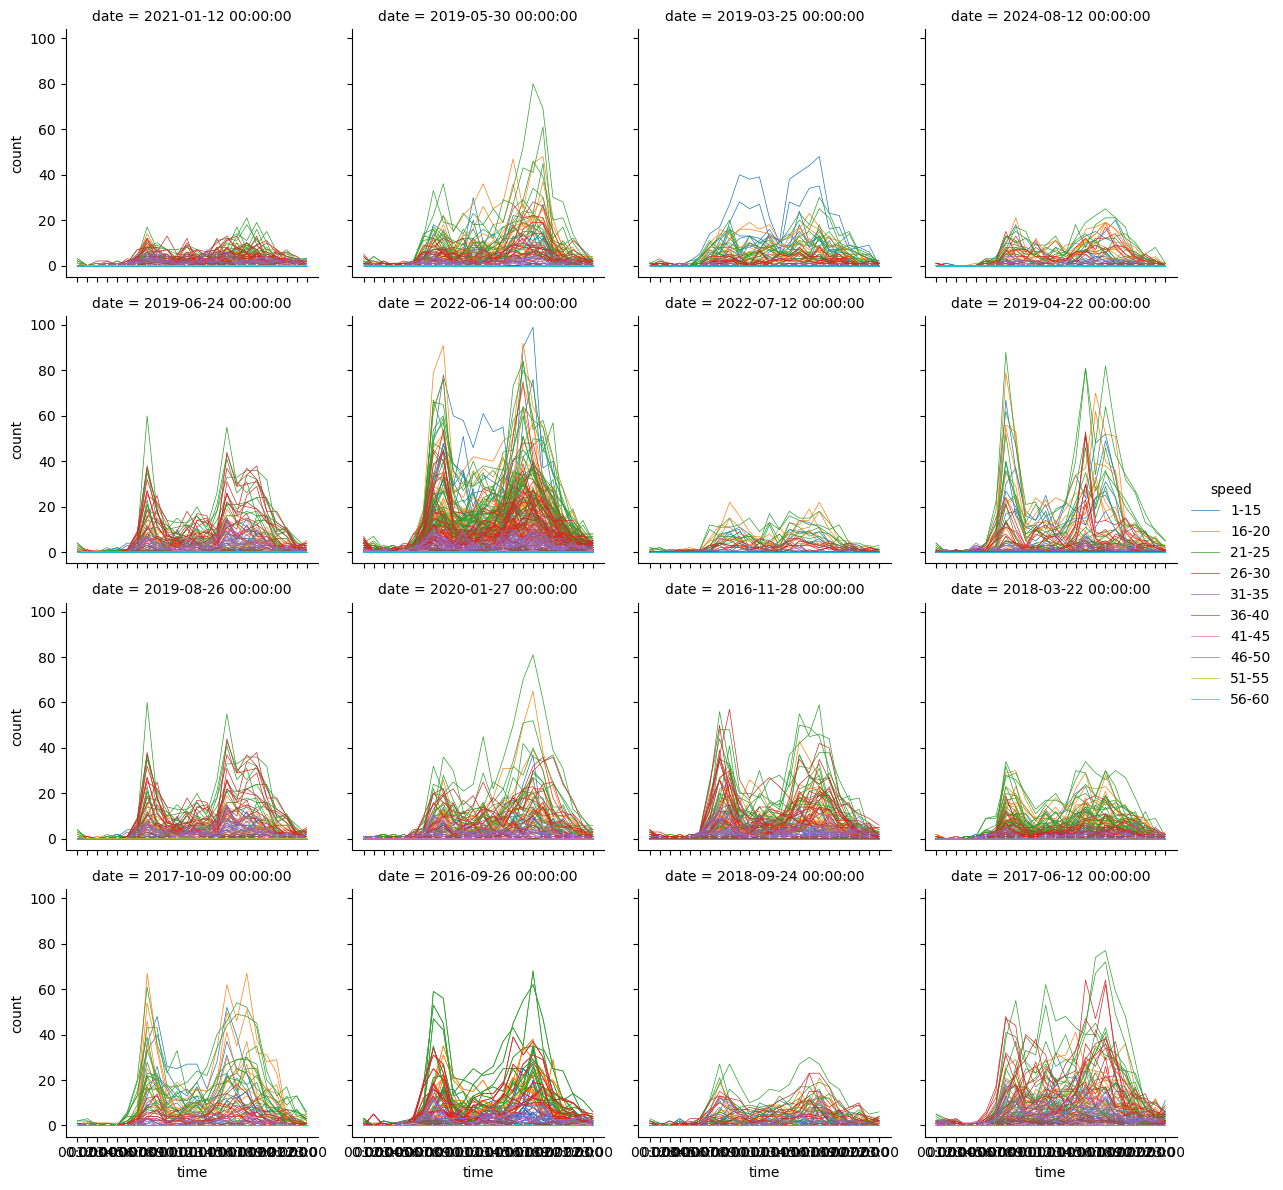

In [805]:
# traffic volume by time
# bigdf.plot(x='time', y='count', kind='scatter', figsize=[12,8], title='Traffic volume')

# sns.scatterplot(data=bigdf, x='time', y='count', hue='speed_min')

# NB: here's how to set type as category
# bigdf['speed_min_cat'] = bigdf['speed_min'].astype('category')

g = sns.FacetGrid(bigdf, col='date', col_wrap=4, hue='speed')
# g.map(sns.scatterplot, 'time', 'count', legend='full')
g.map_dataframe(sns.lineplot, 'time', 'count', units='block', estimator=None, linewidth=0.5)
g.add_legend()

# study = a single traffic study
# is within study variation >> among study variation? if so, would suggest ...?


# is there an NLP processor that can identify GPS coords on a map from something like-
# corner of grove and adams by madison st in oak park


<Axes: xlabel='time', ylabel='count'>

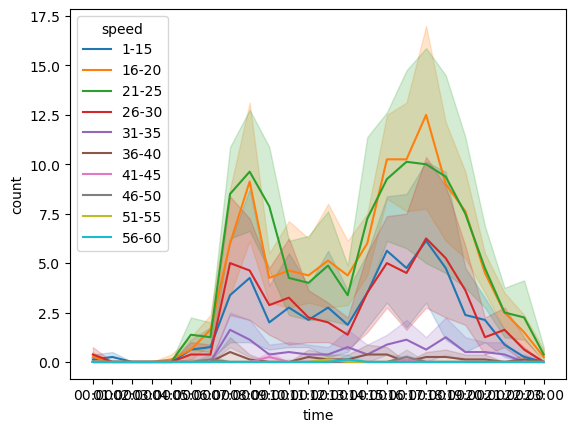

In [627]:
# only our study with error region
bigdf_grove = bigdf[bigdf['date'] == '2024-08-12']
sns.lineplot(bigdf_grove, x='time', y='count', hue='speed')

In [515]:
# stupid fast speeds (n=12 instances)
bigdf[(bigdf['count'] > 0) & (bigdf['speed_min'] > 50)]

,time,speed,count,date,speed_min,speed_max,range
192,00:00,51-55,1.0,2021-01-12,51.0,55.0,4.0
192,00:00,51-55,1.0,2021-01-12,51.0,55.0,4.0
204,12:00,51-55,1.0,2024-08-12,51.0,55.0,4.0
229,13:00,56-60,1.0,2024-08-12,56.0,60.0,4.0
192,00:00,51-55,1.0,2019-06-24,51.0,55.0,4.0
192,00:00,51-55,1.0,2019-06-24,51.0,55.0,4.0
192,00:00,51-55,1.0,2019-08-26,51.0,55.0,4.0
192,00:00,51-55,1.0,2019-08-26,51.0,55.0,4.0
232,16:00,56-60,1.0,2016-09-26,56.0,60.0,4.0
232,16:00,56-60,1.0,2016-09-26,56.0,60.0,4.0


In [ ]:
# Now I need to think of the stats questions I'm interested in!

# 1. Is there a metric I can use to quantify 'problematic' blocks/intersections? Is volume enough?

# 2. Are there some places where excessive speeding (i.e. outliers) is more of a problem?

# 3. How much variation in traffic flow is explained by weather? (maybe)

# 4. TODO - maybe make a webapp where someone can input a new timexspeed matrix and have it predict whether it's "normal" or not?


<Axes: >

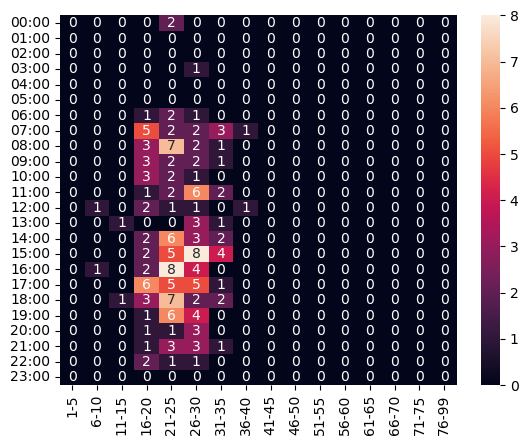

In [517]:
# plots

df = DATA_TABLES_CLEAN[0].df
# df.set_index('time', inplace=True)

sns.heatmap(df, annot=True)

# table 4 problem - has the "total" column at the end (shouldn't!) -  FIXED now!
# problem was the threshold sum for setting row 1 was too low (10) and it was
# shifting everything down


<Axes: >

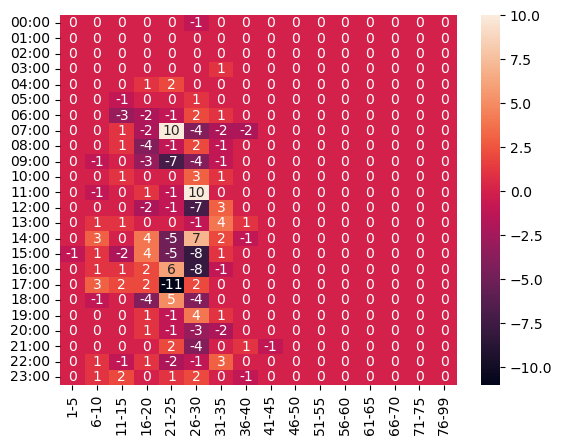

In [518]:
# this is how we can subtract values ignoring dataframe indices

df1 = DATA_TABLES_CLEAN[9].df
df2 = DATA_TABLES_CLEAN[10].df

df_diff = df1 - df2.values

# a heatmap of the differences
sns.heatmap(df_diff, annot=True)

In [521]:
# TODO

# This is in progress- trying to figure out how to get speed data when rows are cutoff by camelot

PDF_INDEX = 11
PAGE_INDEX = 25

# len(DATA_TABLES[PDF_INDEX][PAGE_INDEX].data[5:7])  # NB: this picks 5 and 6 - only UP TO 7, not including 7

# lists = [["a", "b", "c"], ["m", "n", "o"], ["p", "q", "r"]] 
# list(map("".join, zip(*lists)))

list(map("  ".join, zip(*DATA_TABLES[PDF_INDEX][PAGE_INDEX].data[5:7])))

# list(map("".join, zip(*lists)))

# I want to remove any columns (and those to the right of it) that have a dash
# OR - I think most have a sum column that I can look for

['9/19/2023  Time',
 '  0 - 15 MPH',
 '> 15 - 17.5  MPH',
 '  ',
 '> 17.5 - 20  MPH',
 '  ',
 '> 20 - 22.5  MPH',
 '  ',
 '> 22.5 - 25  MPH',
 '  ',
 '> 25 - 27.5  MPH',
 '  ',
 '> 27.5 - 30  MPH',
 '  ',
 '> 30 - 35  MPH',
 '  ',
 '> 35 - 40  MPH',
 '  ',
 '> 40 - 45  MPH',
 '  ',
 '> 45 - 50  MPH',
 '  ',
 '  > 50 MPH',
 '  ',
 '  Total',
 '  ']

In [522]:
## more code-

# parse_table(DATA_TABLES[11][25])

# need a function/code that locates column headings (speed ranges/bins, probably MPH will be in the text)
table = DATA_TABLES[PDF_INDEX][PAGE_INDEX]

list(map("  ".join, zip(*table.data[5:7])))

re.search('MPH', str(table.data)).endpos

re.findall('(Start\s[Dd]ate(:)?)\s*(\d*\/\d*\/\d*)', str(table.data))
# re.findall('(End\s[Dd]ate(:)?)\s*(\d*\/\d*\/\d*)', str(table.data))
# re.findall('(Start Date(:)?)\s*(\d*\/\d*\/\d*)', str(table.data))

str(table.data)

"[['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Start Date: 9/19/2023', '', ''], ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'End Date: 9/20/2023', '', ''], ['Latitude: 41.903721', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['Longitude: -87.788513', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['Direction: West, WB', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['9/19/2023', '', '> 15 - 17.5', '', '> 17.5 - 20', '', '> 20 - 22.5', '', '> 22.5 - 25', '', '> 25 - 27.5', '', '> 27.5 - 30', '', '> 30 - 35', '', '> 35 - 40', '', '> 40 - 45', '', '> 45 - 50', '', '', '', '', ''], ['Time', '0 - 15 MPH', 'MPH', '', 'MPH', '', 'MPH', '', 'MPH', '', 'MPH', '', 'MPH', '', 'MPH', '', 'MPH', '', 'MPH', '', 'MPH', '', '> 50 MPH', '', 'To

In [519]:
# DONE: write a function that collects sum of columns and stops when it reach a column
# that has those sums, removing sum column and ones after
def dropsums(df):
    # get the number of columns
    ncols = len(df.columns)
    for x in range(ncols-1):
        # calculate sum of columns from 0:(x+1) - 
        # this is because iloc selects from 0 up to (but NOT including) x 
        # so we need to use x+1
        thesum = df.iloc[:, 0:(x+1)].sum(axis=1)
        # find columns that sum up to next higher column (i.e., the 'sum' column)
        # single column selection with iloc gives what you'd expect (i.e., column index x)
        if df.iloc[:, x+1].equals(thesum) == True:
            # print('yes')
            return(df.iloc[:, 0:(x+1)])
        # TODO fix this- now it's looping through and will print error even if it finds a sum column
        # else:
            # print('No sum column found, returning original dataframe')
            # return(df)
    
# test the function
# tmp = df1.apply(pd.to_numeric, errors='coerce')

# testing the function further
df = pd.DataFrame({'a': [0, 0, 1],
                   'b': [1, 2, 2],
                   'c': [2, 3, 3],
                   'd': [0, 0, 0],
                   'sum': [3,5,6]})
dropsums(df)
# seems to be working

# produce a cleaned matrix for plotting
# df_clean = dropsums(tmp)
# df_clean

# one problem here is we don't have speed classes in column names
# probably will need to go back to the raw text



,a,b,c,d
0,0,1,2,0
1,0,2,3,0
2,1,2,3,0


In [2496]:
# DONE write function to filter only data tables with hour x speed class data matrix
# see above find_table() function

# here is an example of a non-target dataframe-
# DATA_TABLES[14][1].df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Start Time,Right,Thru,Left,Total,Right,Thru,Left,Total,Approaches,Right,Thru,Left,Total,Right,Thru,Left,Total,Approaches,Total
1,12:00 AM,0,0,0,0,1,1,0,2,2,0,2,0,2,0,2,0,2,4,6
2,1:00 AM,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2
3,2:00 AM,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3:00 AM,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# TODO figure out what's going on with some PDFs that don't have any extracted tables but there are tables in the PDF

PDF = '/Users/chad/Desktop/traffic_pdfs/pdfs_rotated/2023-03-14-transportation-commission-agenda_0.pdf'

tmp = camelot.read_pdf(PDF, pages='77', flavor='stream', strip_text='\n', suppress_stdout=True)
# tmp
tmp[0].df

# re.findall('(\d+:\s*\d\s*\d)((\d*\s*)+).*?(?=\\n)', str(tmp[0].data[0]))

str(tmp[0].data).split()